In [5]:
# Locate one hammer shot by grid searching over precomputed P arrival times


In [6]:
## Import modules
from utils_basic import ROOTDIR, HAMMER_DATE
from utils_snuffler import read_phase_markers
from utils_loc import locate_event_3dgrid, plot_rms
from utils_hammer import get_timewin_from_hammer_name
from pandas import read_csv, to_datetime, DataFrame
from os.path import join
from numpy import load, linspace

In [7]:
## Input parameters
timedir = "traveltimes_subarrays"

subarray = "A"
hammer = "Hammer10-04-39"
phase = "P"

In [8]:
## Read the hammer phase markers
timewin = get_timewin_from_hammer_name(hammer)

if phase == "P":
    inpath = join(ROOTDIR, timewin, f"ppicks_{hammer}.dat")
elif phase == "S":
    inpath = join(ROOTDIR, timewin, f"ppicks_{hammer}.dat")
else:
    raise ValueError("phase must be P or S!")

pickdf = read_phase_markers(inpath)

In [9]:
## Read the precomputed travel time grids

### Read the grid parameters
inpath = join(ROOTDIR, timedir, f"grid_params_{subarray}.csv")
paramdf = read_csv(inpath, sep=" ")
eastmin = paramdf["min_east"][0]
eastmax = paramdf["max_east"][0]
northmin = paramdf["min_north"][0]
northmax = paramdf["max_north"][0]
depthmin = paramdf["min_depth"][0]
depthmax = paramdf["max_depth"][0]

ttimes_of_stations = {}
for i, row in pickdf.iterrows():
    station = row["station"]
    if phase == "P":
        inpath = join(ROOTDIR, timedir, f"ptimes_{station}.npy")
    elif phase == "S":
        inpath = join(ROOTDIR, timedir, f"stimes_{station}.npy")
    else:
        raise ValueError("phase must be P or S!")
    
    try:
        ttimes = load(inpath)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("The pick is removed.")
        pickdf.drop(pickdf[pickdf['station'] == station].index, inplace=True)
        pickdf = pickdf.reset_index(drop=True)
    
    ttimes_of_stations[station] = ttimes

numdepth = ttimes_of_stations[pickdf["station"][0]].shape[0]
numnorth = ttimes_of_stations[pickdf["station"][0]].shape[1]
numeast = ttimes_of_stations[pickdf["station"][0]].shape[2]

eastgrid = linspace(eastmin, eastmax, numeast)
northgrid = linspace(northmin, northmax, numnorth)
depthgrid = linspace(depthmin, depthmax, numdepth)


Error: [Errno 2] No such file or directory: '/Volumes/OmanData/geophones_no_prefilt/data/traveltimes_subarrays/ptimes_A19.npy'
The pick is removed.


In [10]:
## Read the station information
inpath = join(ROOTDIR, "stations.csv")
stadf = read_csv(inpath, index_col=0)

In [11]:
## Locate the event
ievdp, ievno, ievea, evori, rmsvol, atimedict = locate_event_3dgrid(pickdf, ttimes_of_stations, depthgrid, northgrid, eastgrid)

evdepth = depthgrid[ievdp]
evnorth = northgrid[ievno]
eveast = eastgrid[ievea]
rmsmin = rmsvol[ievdp, ievno, ievea]

print(f"Hammer shot location: depth = {evdepth:.1f} m, north = {evnorth:.1f} m, east = {eveast:.1f} m")
print(f"RMS = {rmsmin:.3f} s")

Time elapsed: 145.992736 s.
Hammer shot location: depth = 0.0 m, north = -70.0 m, east = 17.0 m
RMS = 0.001 s


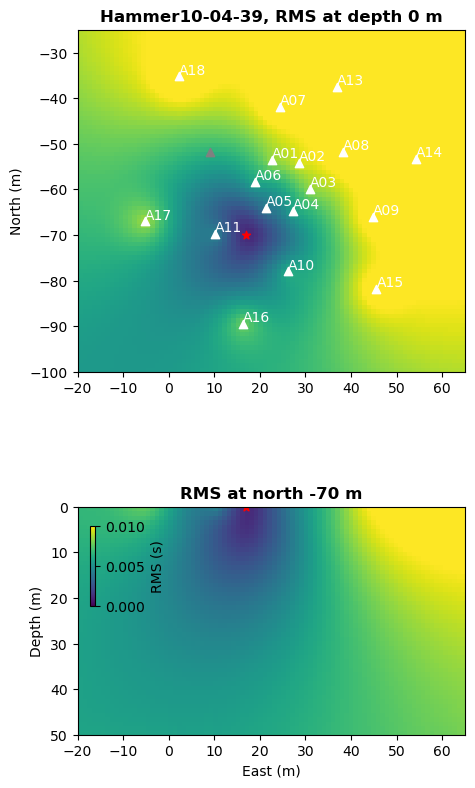

In [12]:
## Plot the RMS map
fig, ax1, ax2, ax3 = plot_rms(rmsvol, ievdp, ievno, ievea, depthgrid, northgrid, eastgrid, stadf, pickdf, hammer, rmsmax=0.01)

In [13]:
## Save the figure
outpath = join(ROOTDIR, timewin, f"rms_{hammer}_{phase}.png")
fig.patch.set_alpha(0)

fig.savefig(outpath, dpi=300)

In [14]:
## Save the results
outpath = join(ROOTDIR, timewin, f"location_{hammer}_{phase}.csv")
locdf = DataFrame({"depth": [evdepth], "north": [evnorth], "east": [eveast], "rms": [rmsmin], "origin_time": [evori.strftime("%Y-%m-%dT%H:%M:%S.%f")]})


locdf["depth"] = locdf["depth"].apply(lambda x: f"{x:.1f}")
locdf["north"] = locdf["north"].apply(lambda x: f"{x:.1f}")
locdf["east"] = locdf["east"].apply(lambda x: f"{x:.1f}")
locdf["rms"] = locdf["rms"].apply(lambda x: f"{x:.3f}")

locdf.to_csv(outpath, sep=" ")